# Machine-Assisted Intent Labeling

You don't yet know the "intent" of all the user utterances in your dataset, but you do not want to have to read and label them all.
The goal is to train a model that can label human utterances with close to 100% test-set accuracy.
with a supervised learning model with a human having read and analyzed as few samples of your dataset as possible.

1. label some portion of your data (label the rest "unknown")
2. train a classifier to classify your data
3. label all the data with your classifier
4. cluster the labeled and "unknown" data with a guess at K
5. assign labels to clusters based on the true label (previously labeled by human) for each cluster
6. measure the accuracy (purity of the clusters other than "unkown")
7. repeat 4-6 several times with new K values and choose the best (highest accuracy) clusters.
8. calculate the total accuracy and number of remaining unkown samples
9. repeat 1-8 several times, creating new labels from some unkowns, and moving some unkowns to a known label

## UX

The UX is the key. Because the human is in the loop, the ML must assist them and guide them in adding new labels or creating new labels. It should not provide too much information nor too little in order to maximize the efficiency of the labler. The goal is to achieve close to 100% test-set accuracy with a supervised learning model with a human having read and analyzed as few samples of your dataset as possible.



In [1]:
from pathlib import Path
import pandas as pd
import numpy as np
import json

pd.options.display.max_columns = 1000

In [2]:
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import ticker
import seaborn as sns

sns.set_style('white')
sns.set_theme('notebook')

In [3]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

from sklearn.model_selection import train_test_split

In [4]:
from collections import Counter
from sklearn.metrics import confusion_matrix, f1_score

In [5]:
EXPERIMENTS = []
ENCODER = 'sbert'

DATA_DIR = Path('.') / 'data'
FILEPATH = DATA_DIR / 'utterance_intent_pairs_revised.csv'
# FILEPATH = DATA_DIR / 'utterance_intent_pairs_augmented.csv'
# FILEPATH = DATA_DIR / 'augumented_utterance_intent_pairs.csv'
MIN_EXAMPLES = 4  # minimum number of example utterance per intent (class label), user will be asked to supply paraphrases

In [6]:
df = pd.read_csv(FILEPATH)
df = df[['utterance', 'intent']].copy()
df['intent'] = df['intent'].str.lower().str.strip().str.replace(' ', '_').str.replace('-', '_')
print(df.shape)
utterances = list(df['utterance'].fillna(''))
intents = list(df['intent'].copy().fillna('unknown'))
counts = pd.Series(Counter(intents)).sort_values()
counts

(1094, 2)


watched_videos                4
how_are_you                   4
both_languages                4
restart                       4
ask_question                  5
insurance_for_work            6
quiz_module                   6
addressing_maya               7
testing_you                   7
how_to_get_involved           7
other_languages               7
stories_module                7
what_is_unsafe_migration      8
main_menu                     8
stupid_bot                   10
no                           10
scary_or_terrible            10
documents_needed             11
continue                     16
yes                          16
i_love_you                   16
safe_behaviors               16
information                  16
online_safety                18
where_are_you_from           20
what_is_trafficking          22
change_language              28
thank_you                    30
emergency                    33
who_are_you_maya             35
goodbye                      35
hello   

In [7]:
counts_dict = counts.to_dict()
counts_dict

{'watched_videos': 4,
 'how_are_you': 4,
 'both_languages': 4,
 'restart': 4,
 'ask_question': 5,
 'insurance_for_work': 6,
 'quiz_module': 6,
 'addressing_maya': 7,
 'testing_you': 7,
 'how_to_get_involved': 7,
 'other_languages': 7,
 'stories_module': 7,
 'what_is_unsafe_migration': 8,
 'main_menu': 8,
 'stupid_bot': 10,
 'no': 10,
 'scary_or_terrible': 10,
 'documents_needed': 11,
 'continue': 16,
 'yes': 16,
 'i_love_you': 16,
 'safe_behaviors': 16,
 'information': 16,
 'online_safety': 18,
 'where_are_you_from': 20,
 'what_is_trafficking': 22,
 'change_language': 28,
 'thank_you': 30,
 'emergency': 33,
 'who_are_you_maya': 35,
 'goodbye': 35,
 'hello': 72,
 'ok': 90,
 'unknown': 506}

In [8]:
new_utterances = []
new_intents = []

for label in counts_dict:
    print('='*10, label, '='*10)
    while counts_dict[label] < MIN_EXAMPLES:
        sep = '\n    '
        print(f'Input a new utterance for "{label}". Examples: {sep}')
        print(sep.join(df['utterance'][df['intent'] == label]))
        utt = input('YOUR NEW UTTERANCE: ')
        new_utterances.append(utt)
        new_intents.append(label)
        counts_dict[label] += 1
intents += new_intents
utterances += new_utterances


========== watched_videos ==========
========== how_are_you ==========
========== both_languages ==========
========== restart ==========
========== ask_question ==========
========== insurance_for_work ==========
========== quiz_module ==========
========== addressing_maya ==========
========== testing_you ==========
========== how_to_get_involved ==========
========== other_languages ==========
========== stories_module ==========
========== what_is_unsafe_migration ==========
========== main_menu ==========
========== stupid_bot ==========
========== no ==========
========== scary_or_terrible ==========
========== documents_needed ==========
========== continue ==========
========== yes ==========
========== i_love_you ==========
========== safe_behaviors ==========
========== information ==========
========== online_safety ==========
========== where_are_you_from ==========
========== what_is_trafficking ==========
========== change_language ==========
========== thank_you ========

In [9]:
FILEPATH

PosixPath('data/utterance_intent_pairs_revised.csv')

In [10]:
df = pd.DataFrame({'utterance': utterances, 'intent': intents})
df.to_csv(FILEPATH.with_suffix('.augmented.csv'), index=False)
df

utterance               intent
0                                              "*menu*"            main_menu
1                                         ", thank you"            thank_you
2                              "1. What is trafficking"  what_is_trafficking
3                                 "2. Safety behaviors"       safe_behaviors
4     "A question the system is not supposed to reco...          testing_you
...                                                 ...                  ...
1089                             Tell me more about it.          information
1090                               nepalese and english       both_languages
1091                     I'd like to ask you something.         ask_question
1092                                  How was your day?          how_are_you
1093                                    tell me a story       stories_module

[1094 rows x 2 columns]

In [11]:
sorted(df['intent'].unique())

['addressing_maya',
 'ask_question',
 'both_languages',
 'change_language',
 'continue',
 'documents_needed',
 'emergency',
 'goodbye',
 'hello',
 'how_are_you',
 'how_to_get_involved',
 'i_love_you',
 'information',
 'insurance_for_work',
 'main_menu',
 'no',
 'ok',
 'online_safety',
 'other_languages',
 'quiz_module',
 'restart',
 'safe_behaviors',
 'scary_or_terrible',
 'stories_module',
 'stupid_bot',
 'testing_you',
 'thank_you',
 'unknown',
 'watched_videos',
 'what_is_trafficking',
 'what_is_unsafe_migration',
 'where_are_you_from',
 'who_are_you_maya',
 'yes']

In [12]:
if counts.sum() != len(df):
    ans = input(f"Would you like to overwrite the origin dataset ({counts.sum()}x2) with the new one ({df.shape[0]}x2)?")
    if ans and ans[0] in 'yY':
        df.to_csv(FILEPATH, index=False)
        print(f"Wrote dataset to '{FILEPATH}'")
    else:
        print(f"Retained new augmented dataset in '{FILEPATH.with_suffix('.augmented.csv')}'")

In [13]:
counts = pd.Series(Counter(intents)).sort_values()
counts

watched_videos                4
how_are_you                   4
both_languages                4
restart                       4
ask_question                  5
insurance_for_work            6
quiz_module                   6
addressing_maya               7
testing_you                   7
how_to_get_involved           7
other_languages               7
stories_module                7
what_is_unsafe_migration      8
main_menu                     8
stupid_bot                   10
no                           10
scary_or_terrible            10
documents_needed             11
continue                     16
yes                          16
i_love_you                   16
safe_behaviors               16
information                  16
online_safety                18
where_are_you_from           20
what_is_trafficking          22
change_language              28
thank_you                    30
emergency                    33
who_are_you_maya             35
goodbye                      35
hello   

In [14]:
intents[:20]

['main_menu',
 'thank_you',
 'what_is_trafficking',
 'safe_behaviors',
 'testing_you',
 'thank_you',
 'who_are_you_maya',
 'stupid_bot',
 'goodbye',
 'main_menu',
 'other_languages',
 'testing_you',
 'both_languages',
 'both_languages',
 'goodbye',
 'goodbye',
 'goodbye',
 'goodbye',
 'goodbye',
 'goodbye']

In [15]:
if ENCODER == 'spacy':
    # https://spacy.io
    import spacy
    nlp = 'en_core_web_md'
    try:
        nlp = spacy.load(nlp)
    except OSError:
        spacy.cli.download(nlp)
    nlp = spacy.load(nlp) if isinstance(nlp, str) else nlp
    def encoder(s):
        return nlp(s).vector
elif ENCODER == 'sbert':
    # https://www.sbert.net/
    from sentence_transformers import SentenceTransformer
    sbert = SentenceTransformer('paraphrase-MiniLM-L6-v2')
    def encoder(s):
        return sbert.encode(s)

In [16]:
X_sbert = pd.DataFrame([sbert.encode(s) for s in utterances])
Y_sbert = pd.DataFrame([sbert.encode(s) for s in intents])
print(X_sbert.shape)
print(Y_sbert.shape)

(1094, 384)
(1094, 384)


In [17]:
df

utterance               intent
0                                              "*menu*"            main_menu
1                                         ", thank you"            thank_you
2                              "1. What is trafficking"  what_is_trafficking
3                                 "2. Safety behaviors"       safe_behaviors
4     "A question the system is not supposed to reco...          testing_you
...                                                 ...                  ...
1089                             Tell me more about it.          information
1090                               nepalese and english       both_languages
1091                     I'd like to ask you something.         ask_question
1092                                  How was your day?          how_are_you
1093                                    tell me a story       stories_module

[1094 rows x 2 columns]

In [18]:
X = X_sbert.values
y = intents
X[0].round(2), y[0]

(array([-0.19,  0.35, -0.4 , -0.28, -0.89,  0.16,  0.52, -0.56,  0.25,
        -0.04, -0.38, -0.2 , -0.17, -0.3 ,  0.12, -0.12,  0.64, -0.18,
        -0.19, -0.54,  0.14, -0.05, -0.66,  0.27, -0.31, -0.  , -0.42,
         0.07, -0.13, -0.26,  0.03,  0.39,  0.2 ,  0.07,  0.17,  0.53,
        -0.03, -0.07, -0.28, -0.56, -0.08,  0.01, -0.7 ,  0.1 ,  0.12,
        -0.92, -0.44, -0.18, -0.01,  0.34, -0.69,  0.29, -0.45, -0.36,
         0.33,  0.43, -0.06,  0.02,  0.07,  0.17, -0.33, -0.55, -0.16,
         0.65,  0.69,  0.24, -0.35,  0.01, -0.47,  0.81, -0.51, -0.29,
         0.2 ,  0.13,  0.62, -0.14,  0.01, -0.58, -0.54,  0.02,  0.19,
         0.13, -0.13, -0.13, -0.04,  0.29, -0.26, -0.48,  0.16, -0.39,
        -0.15, -0.58,  0.18,  0.45,  0.03, -0.35, -0.29, -0.61, -0.5 ,
         0.4 ,  0.32,  0.24,  1.06, -0.14,  0.04, -0.1 ,  0.21,  0.09,
        -0.53,  0.13, -0.3 ,  0.58,  0.59, -0.33, -0.9 , -0.55,  0.15,
        -0.2 ,  0.4 ,  0.18,  0.14,  0.35, -0.08,  0.26, -0.02,  0.17,
      

In [19]:
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.1, random_state=42)
# X_train.shape, len(y_train), X_test.shape, len(y_test)

In [20]:
X_train, X_test, y_train, y_test = X, X, y, y

In [21]:
hyperparams = dict(C=1, class_weight='balanced', random_state=1, max_iter=10000, multi_class='auto')
model = LogisticRegression(**hyperparams)
model.fit(X_train, y_train)
model

LogisticRegression(C=1, class_weight='balanced', max_iter=10000, random_state=1)

In [22]:
model.classes_

array(['addressing_maya', 'ask_question', 'both_languages',
       'change_language', 'continue', 'documents_needed', 'emergency',
       'goodbye', 'hello', 'how_are_you', 'how_to_get_involved',
       'i_love_you', 'information', 'insurance_for_work', 'main_menu',
       'no', 'ok', 'online_safety', 'other_languages', 'quiz_module',
       'restart', 'safe_behaviors', 'scary_or_terrible', 'stories_module',
       'stupid_bot', 'testing_you', 'thank_you', 'unknown',
       'watched_videos', 'what_is_trafficking',
       'what_is_unsafe_migration', 'where_are_you_from',
       'who_are_you_maya', 'yes'], dtype='<U24')

In [23]:
y_test_pred = model.predict(X_test)
confusion_test = pd.DataFrame(
    confusion_matrix(
        y_test, y_test_pred, labels=model.classes_),
    index=model.classes_,
    columns=model.classes_)
confusion_test

addressing_maya  ask_question  both_languages  \
addressing_maya                         7             0               0   
ask_question                            0             5               0   
both_languages                          0             0               4   
change_language                         0             0               0   
continue                                0             0               0   
documents_needed                        0             0               0   
emergency                               0             0               0   
goodbye                                 0             0               0   
hello                                   0             0               0   
how_are_you                             0             0               0   
how_to_get_involved                     0             0               0   
i_love_you                              0             0               0   
information                             0             0               0   
insurance_for_work                      0             0               0   
main_menu                               0             0               0   
no                                      0             0               0   
ok                                      0             0               0   
online_safety                           0             0               0   
other_languages                         0             0               0   
quiz_module                             0             0               0   
restart                                 0             0               0   
safe_behaviors                          0             0               0   
scary_or_terrible                       0             0               0   
stories_module                          0             0               0   
stupid_bot                              0             0               0   
testing_you                             0             0               0   
thank_you                               0             0               0   
unknown                                 0             5               0   
watched_videos                          0             0               0   
what_is_trafficking                     0             0               0   
what_is_unsafe_migration                0             0               0   
where_are_you_from                      0             0               0   
who_are_you_maya                        0             0               0   
yes                                     0             0               0   

                          change_language  continue  documents_needed  \
addressing_maya                         0         0                 0   
ask_question                            0         0                 0   
both_languages                          0         0                 0   
change_language                        28         0                 0   
continue                                0        15                 0   
documents_needed                        0         0                11   
emergency                               0         0                 0   
goodbye                                 0         0                 0   
hello                                   0         0                 0   
how_are_you                             0         0                 0   
how_to_get_involved                     0         0                 0   
i_love_you                              0         0                 0   
information                             0         0                 0   
insurance_for_work                      0         0                 0   
main_menu                               0         0                 0   
no                                      0         0                 0   
ok                                      1         1                 0   
online_safety                           0         0                 0   
other_languag

In [24]:
df['intent_pred'] = model.predict(X)
confusion_all = pd.DataFrame(
    confusion_matrix(
        df['intent'], df['intent_pred'], labels=model.classes_),
    index=model.classes_,
    columns=model.classes_)

In [25]:
confusion_test_pct = (confusion_test / confusion_test.sum()).fillna(0).round(2)
confusion_test_pct
confusion_all_pct = (confusion_all / confusion_all.sum()).fillna(0).round(2)
confusion_all_pct

addressing_maya  ask_question  both_languages  \
addressing_maya                       1.0           0.0             0.0   
ask_question                          0.0           0.5             0.0   
both_languages                        0.0           0.0             1.0   
change_language                       0.0           0.0             0.0   
continue                              0.0           0.0             0.0   
documents_needed                      0.0           0.0             0.0   
emergency                             0.0           0.0             0.0   
goodbye                               0.0           0.0             0.0   
hello                                 0.0           0.0             0.0   
how_are_you                           0.0           0.0             0.0   
how_to_get_involved                   0.0           0.0             0.0   
i_love_you                            0.0           0.0             0.0   
information                           0.0           0.0             0.0   
insurance_for_work                    0.0           0.0             0.0   
main_menu                             0.0           0.0             0.0   
no                                    0.0           0.0             0.0   
ok                                    0.0           0.0             0.0   
online_safety                         0.0           0.0             0.0   
other_languages                       0.0           0.0             0.0   
quiz_module                           0.0           0.0             0.0   
restart                               0.0           0.0             0.0   
safe_behaviors                        0.0           0.0             0.0   
scary_or_terrible                     0.0           0.0             0.0   
stories_module                        0.0           0.0             0.0   
stupid_bot                            0.0           0.0             0.0   
testing_you                           0.0           0.0             0.0   
thank_you                             0.0           0.0             0.0   
unknown                               0.0           0.5             0.0   
watched_videos                        0.0           0.0             0.0   
what_is_trafficking                   0.0           0.0             0.0   
what_is_unsafe_migration              0.0           0.0             0.0   
where_are_you_from                    0.0           0.0             0.0   
who_are_you_maya                      0.0           0.0             0.0   
yes                                   0.0           0.0             0.0   

                          change_language  continue  documents_needed  \
addressing_maya                      0.00      0.00               0.0   
ask_question                         0.00      0.00               0.0   
both_languages                       0.00      0.00               0.0   
change_language                      0.90      0.00               0.0   
continue                             0.00      0.75               0.0   
documents_needed                     0.00      0.00               1.0   
emergency                            0.00      0.00               0.0   
goodbye                              0.00      0.00               0.0   
hello                                0.00      0.00               0.0   
how_are_you                          0.00      0.00               0.0   
how_to_get_involved                  0.00      0.00               0.0   
i_love_you                           0.00      0.00               0.0   
information                          0.00      0.00               0.0   
insurance_for_work                   0.00      0.00               0.0   
main_menu                            0.00      0.00               0.0   
no                                   0.00      0.00               0.0   
ok                                   0.03      0.05               0.0   
online_safety                        0.00      0.00               0.0   
other_languag

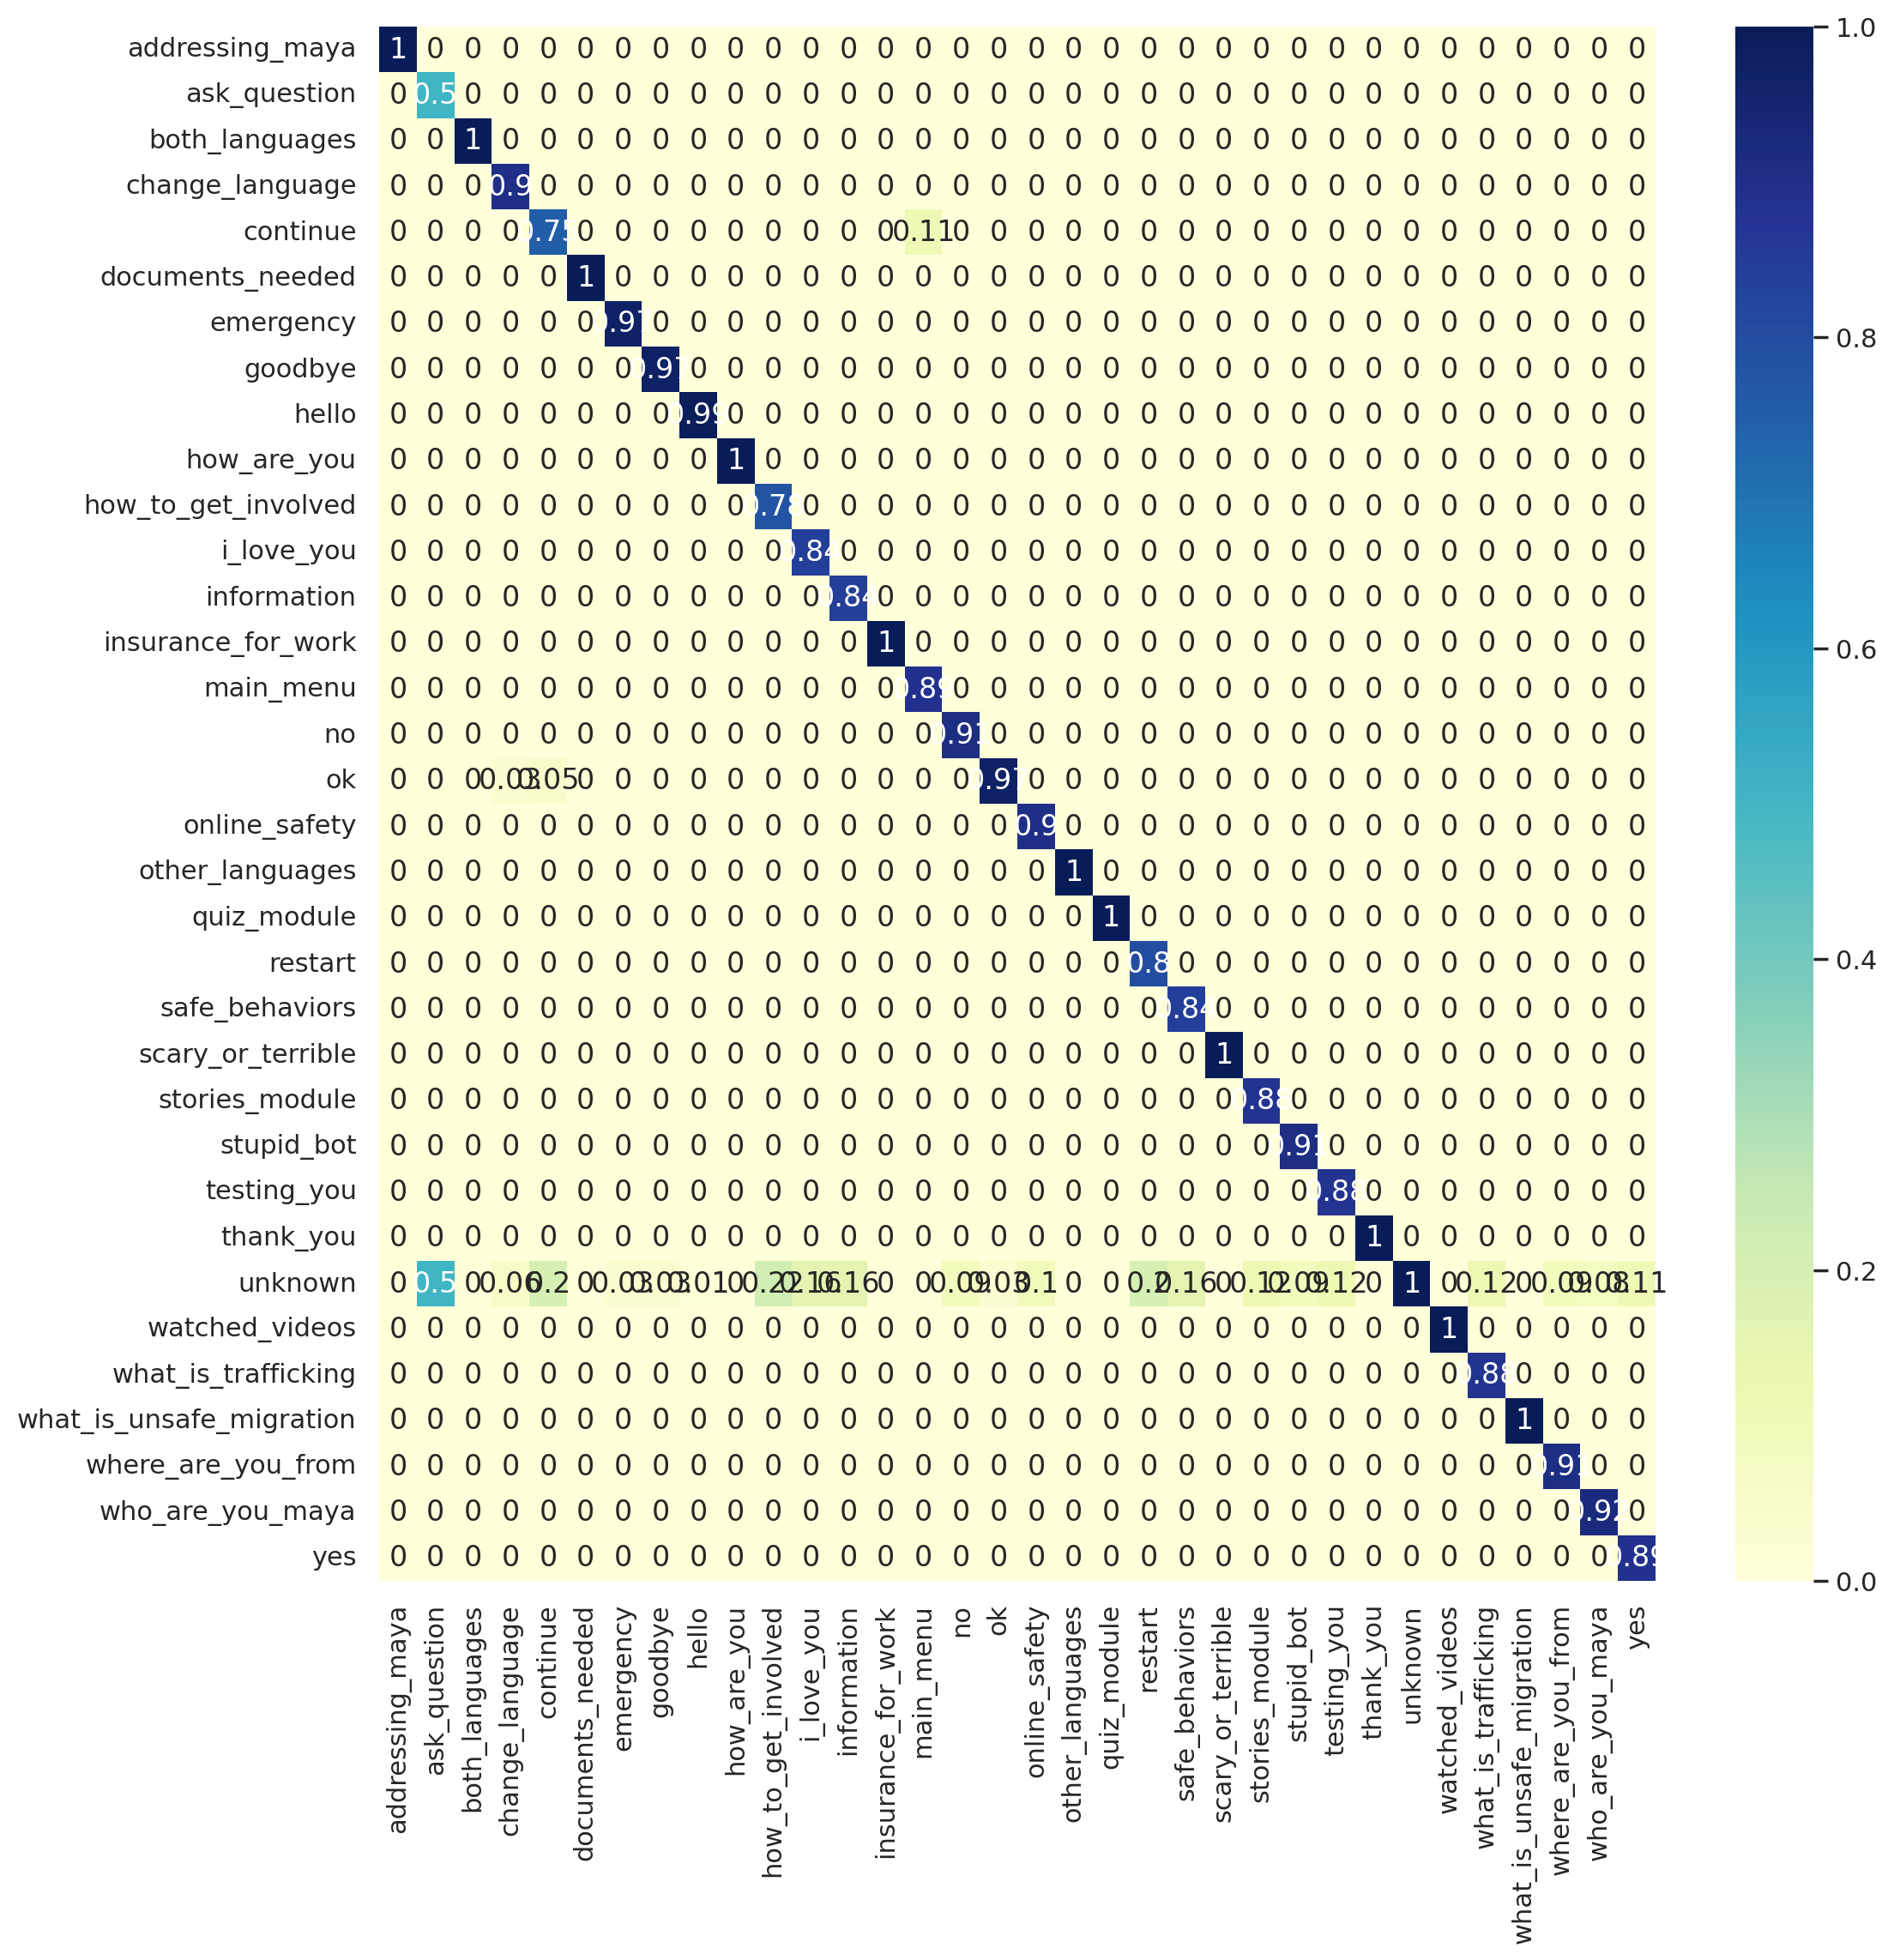

In [26]:
plt.rcParams['figure.figsize'] = [12,12]
fig = plt.figure(figsize=[12,12], dpi=200)
ax = fig.add_subplot(111)
cax = sns.heatmap(confusion_test_pct, annot=True, cmap="YlGnBu")

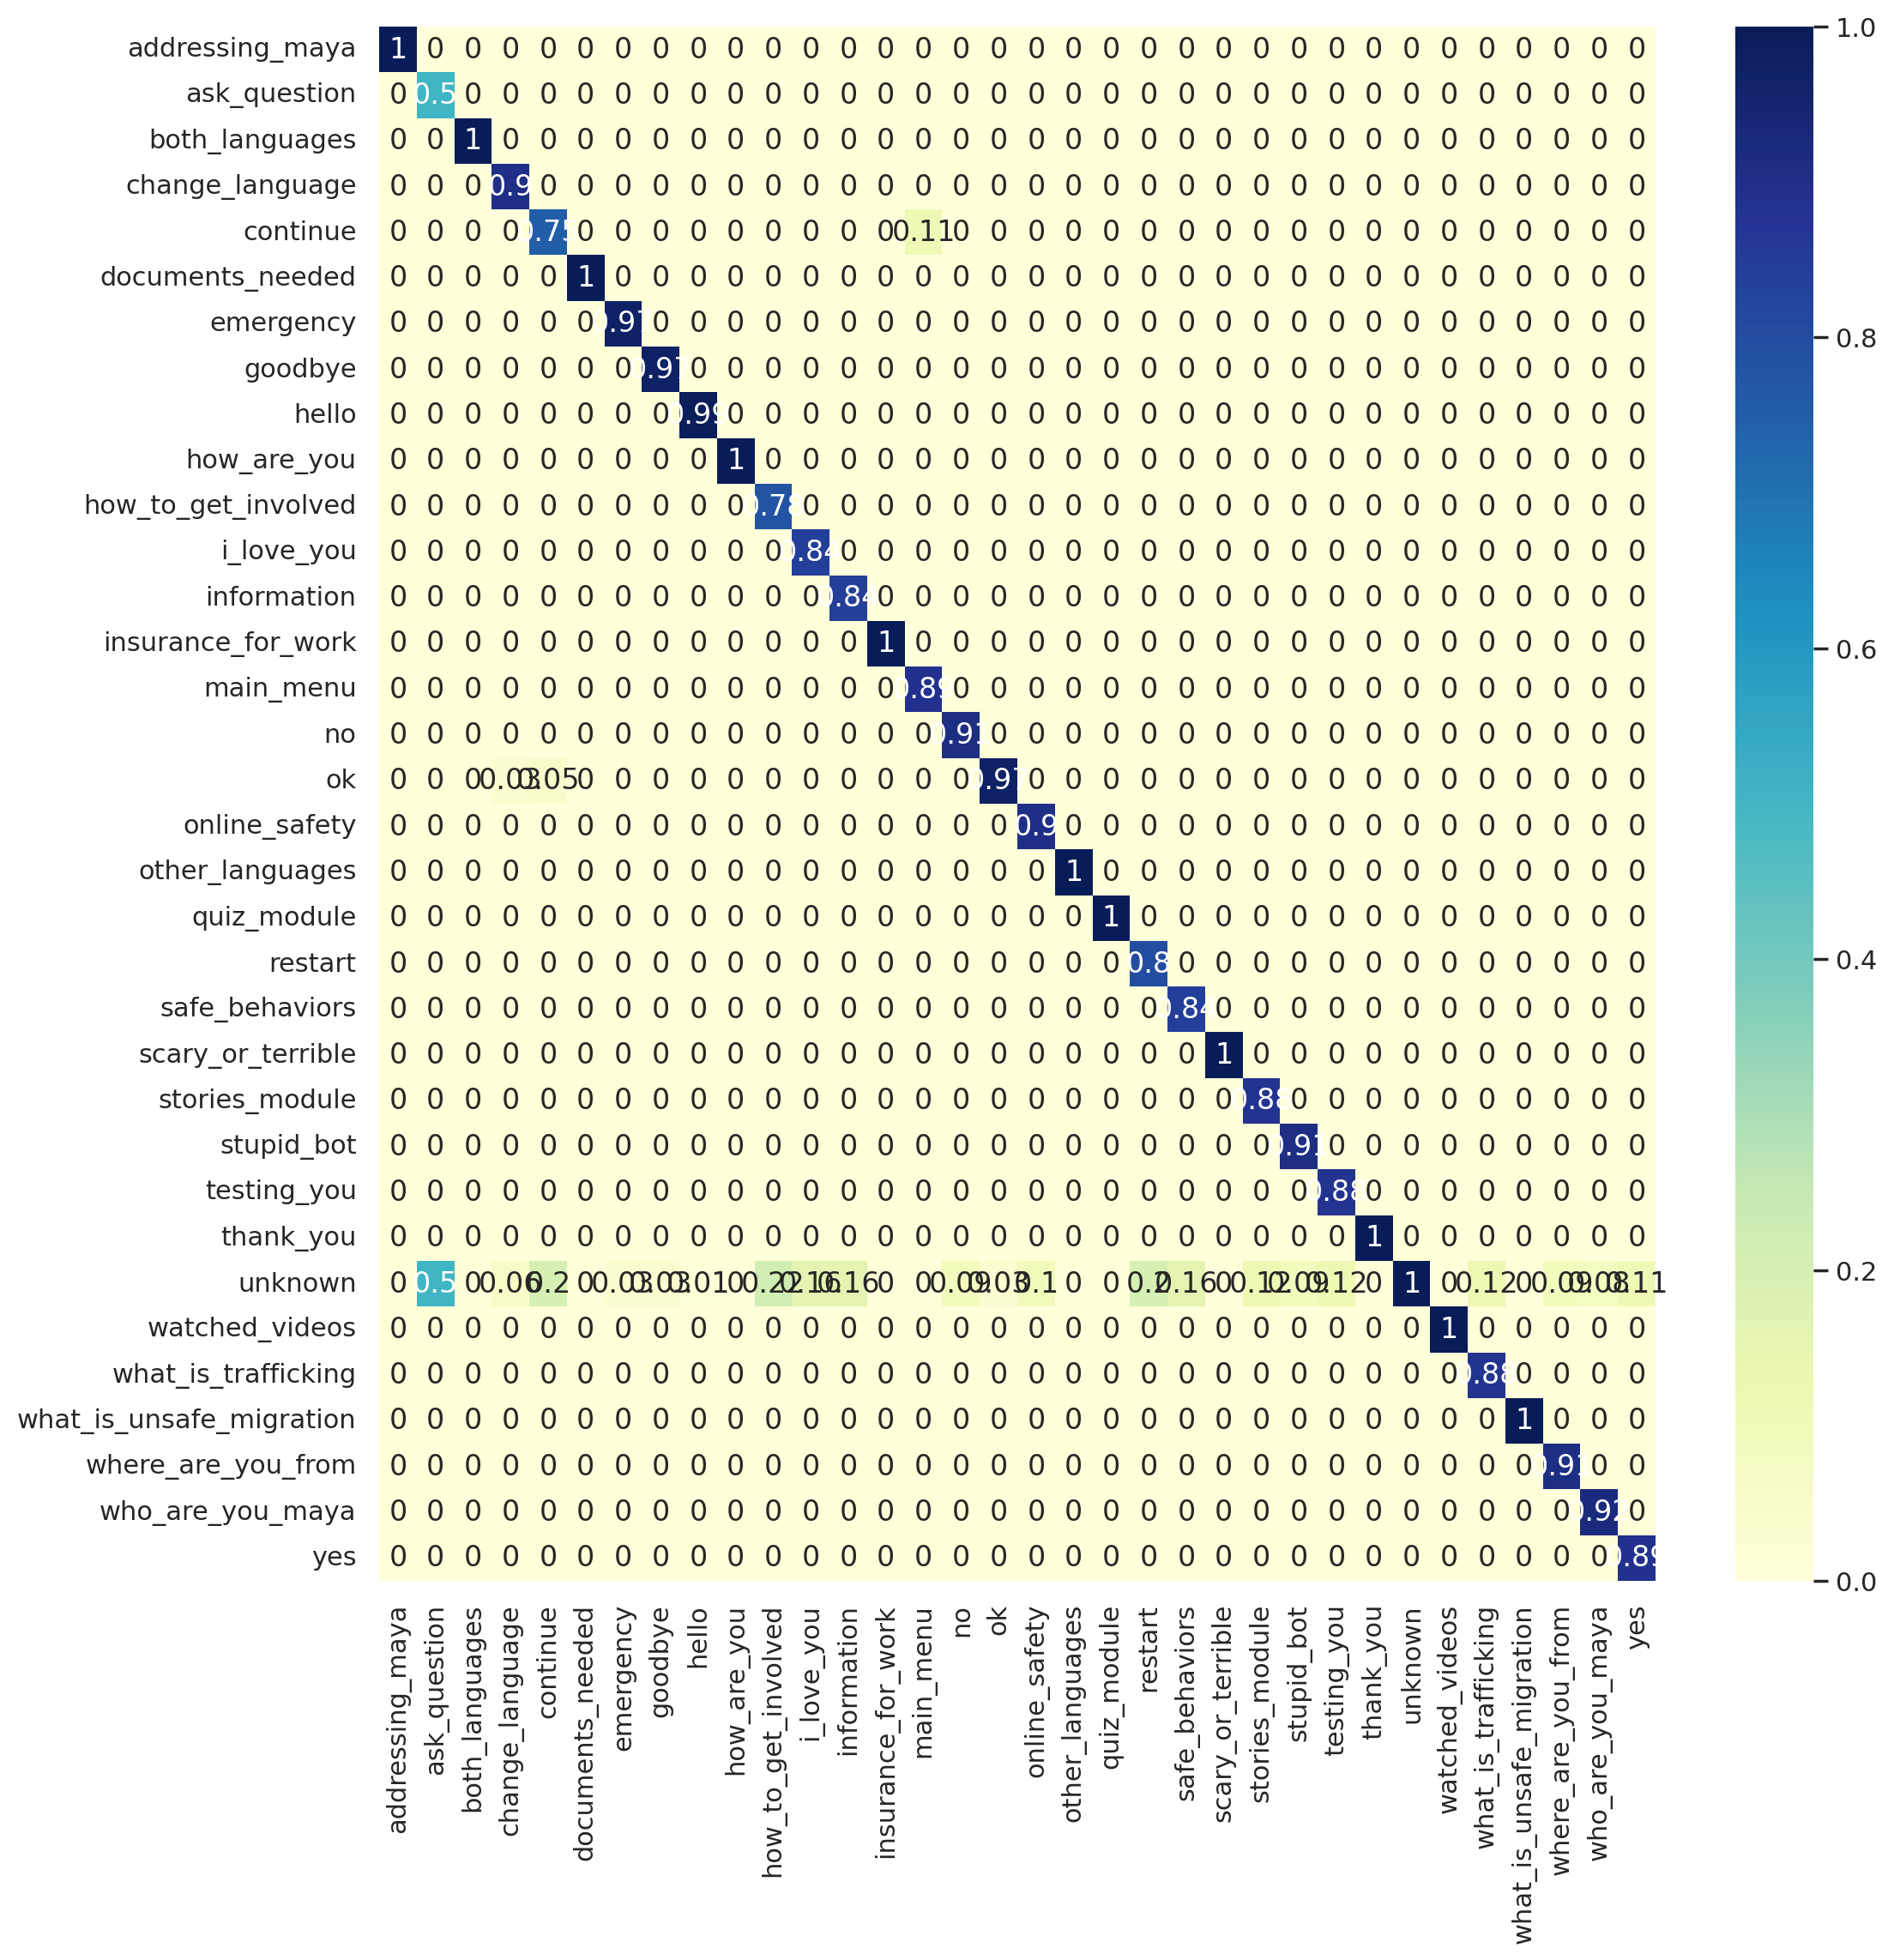

In [27]:
plt.rcParams['figure.figsize'] = [12,12]
fig = plt.figure(figsize=[12,12], dpi=200)
ax = fig.add_subplot(111)
cax = sns.heatmap(confusion_all_pct, annot=True, cmap="YlGnBu")

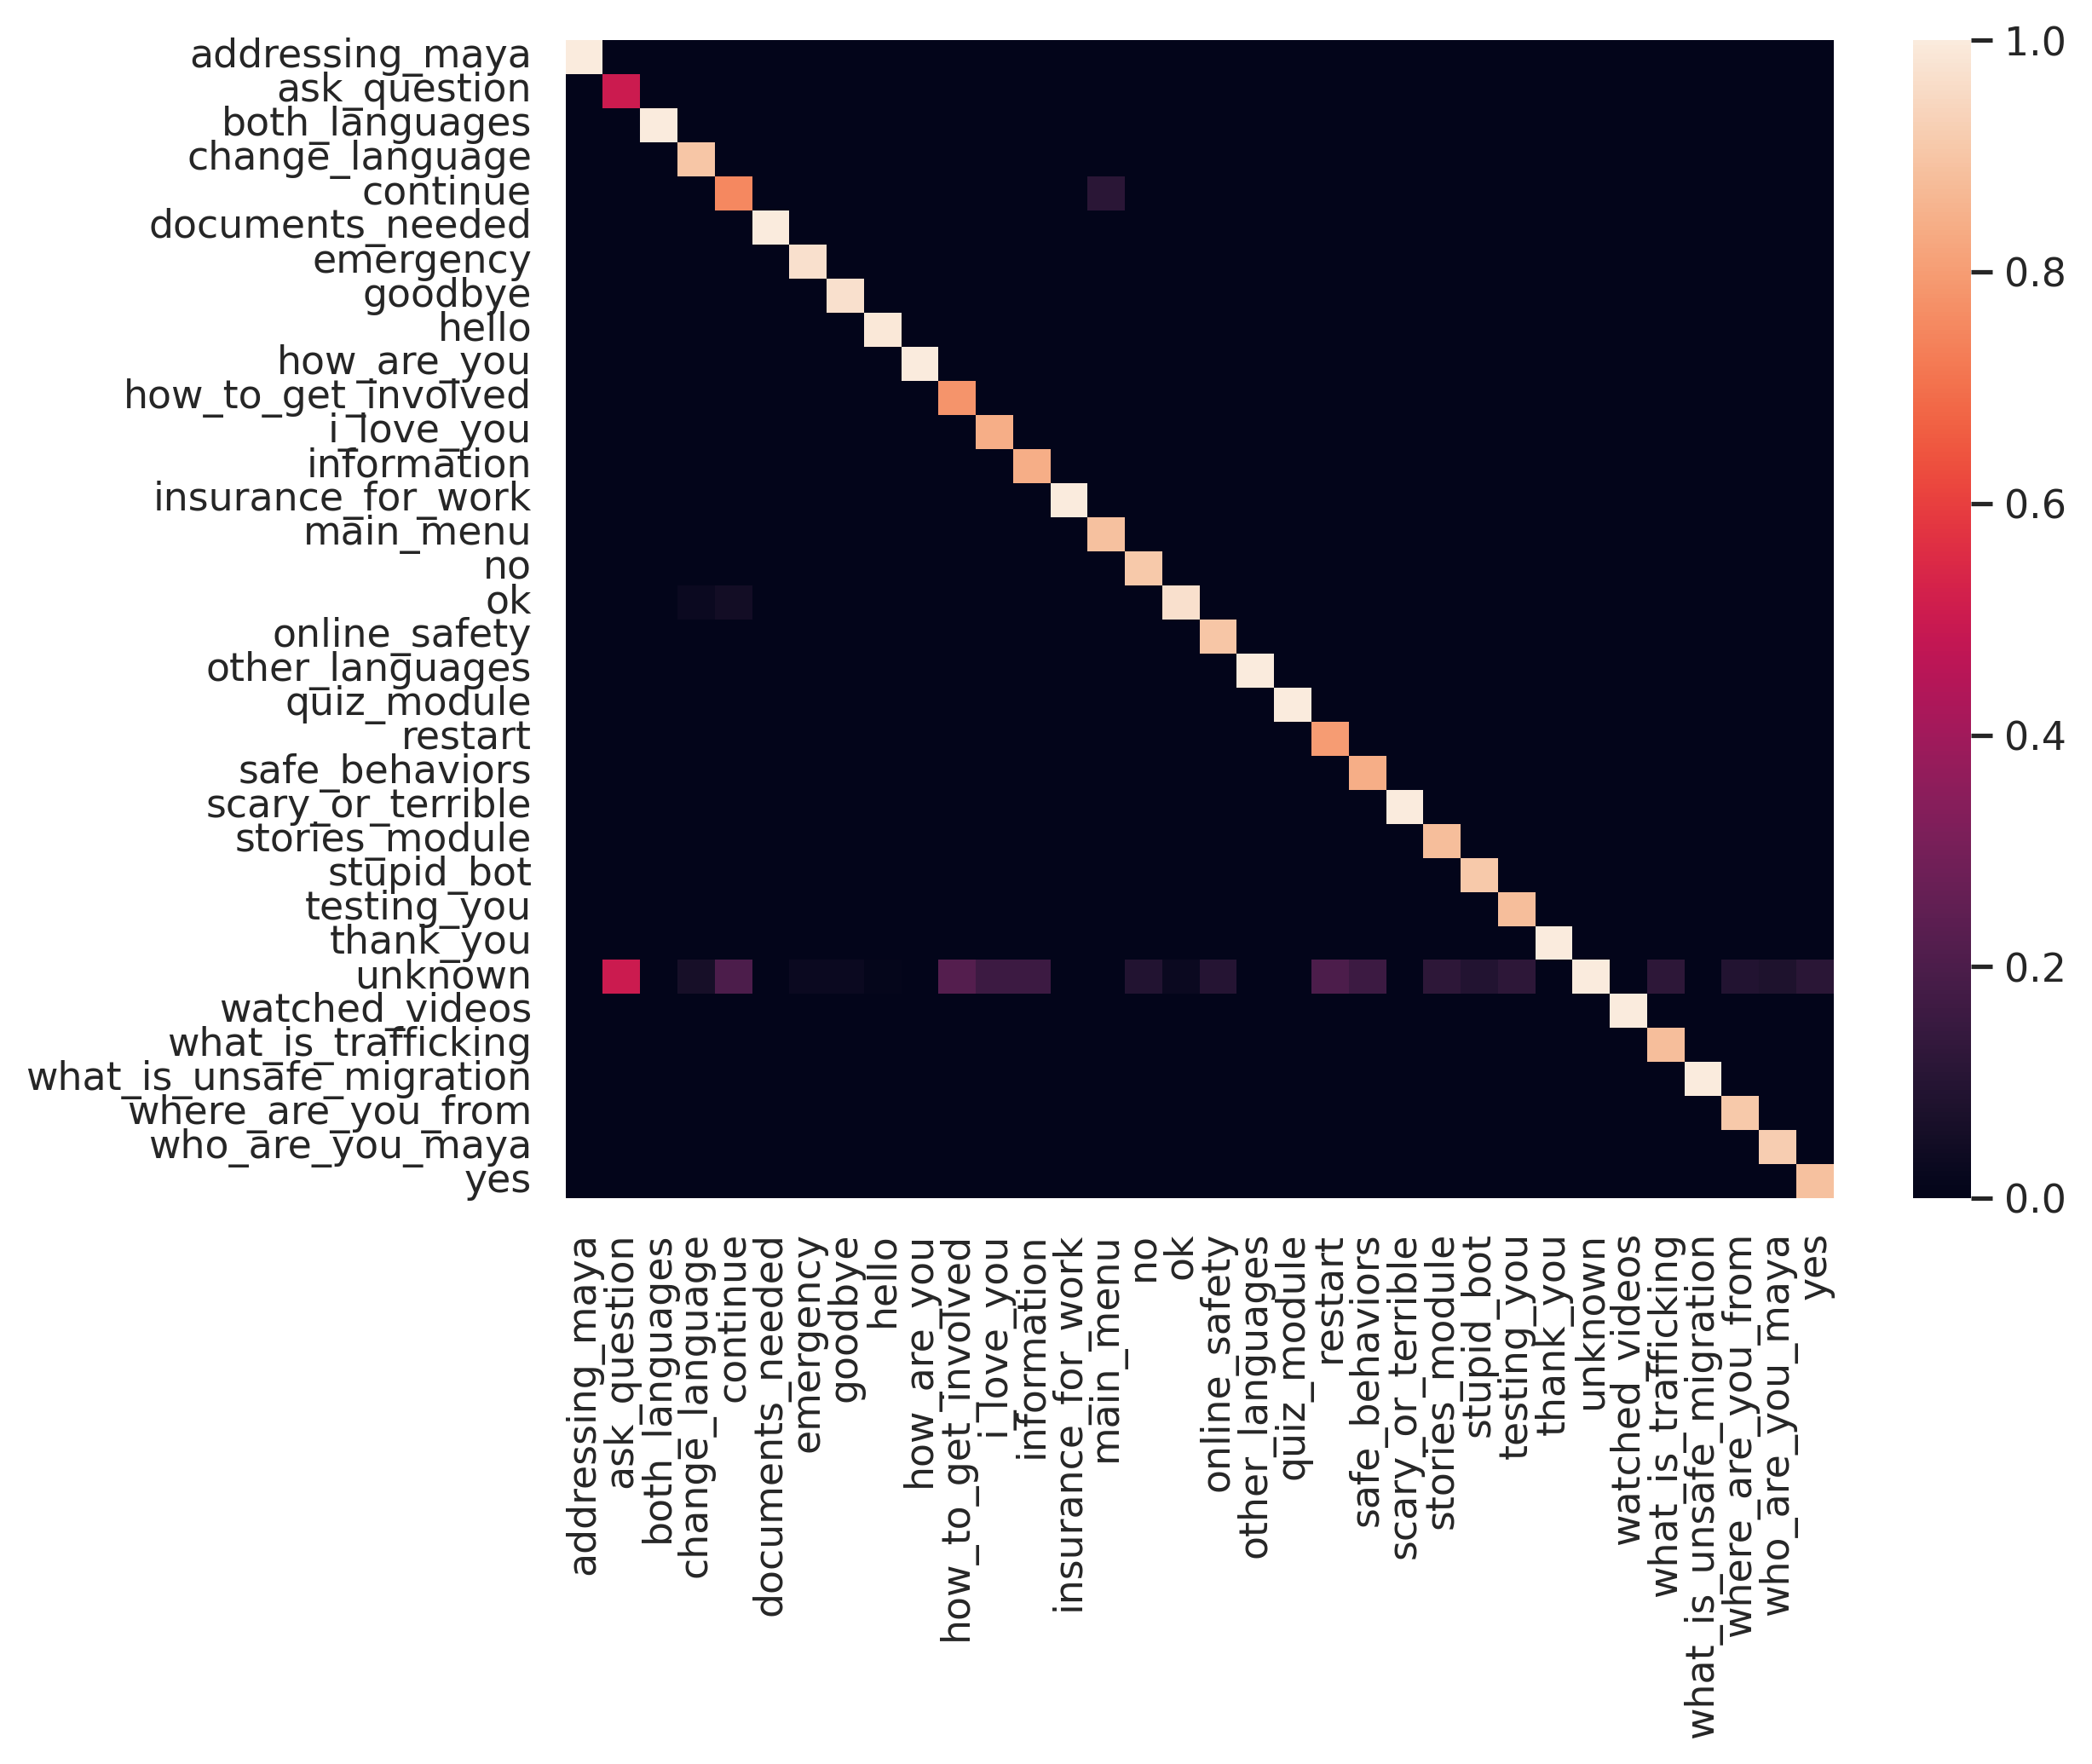

In [28]:
plt.rcParams['figure.figsize'] = [8,6]
fig = plt.figure(figsize=[8,6], dpi=300)
ax = fig.add_subplot(111)
cax = sns.heatmap(confusion_all_pct, vmin=0, vmax=1)

ax.set_xticks(np.arange(len(model.classes_)) + .5)
ax.set_xticklabels(list(model.classes_), rotation=90)

ax.set_yticks(np.arange(len(model.classes_)) + .5)
ax.set_yticklabels(list(model.classes_))

plt.show()

In [29]:
df['intent_pred'] = pd.Series(y_pred)

NameError: name 'y_pred' is not defined

In [ ]:
incorrect_pred = df['intent_pred'] != df['intent']
unknown = (df['intent'] == 'unknown') | (df['intent_pred'] == 'unknown')
suspicious_rows = incorrect_pred & unknown
reconsider = df[suspicious_rows]

pd.options.display.max_rows = 200
reconsider

In [ ]:
pd.concat([g.iloc[[0]] for (label, g) in df.groupby('intent')])

In [ ]:
intent_dict = df['intent'].to_dict()
corrections = {22: 'stories_module', 481: 'i_love_you'}
intent_dict.update(corrections)
df['corrected'] = pd.Series(corrections)
df.iloc[list(corrections.keys())]

In [ ]:
def revise_unknown_labels(df, reconsider, your_labels):
    for i_recon, (idx, row) in enumerate(reconsider.iterrows()):
        print()
        print(f'{idx}: "{row["utterance"]}"   [l]abel: {row["intent"]}   [p]red: {row["intent_pred"]}')
        your_label = input(f'YOUR LABEL ([l]abel="{row["intent"]}", [p]red, e[x]it, [s]kip, <your_suggestion>, [ENTER]="{row["intent_pred"]}"): ')
        try:
            your_label = int(your_label)
            your_label = df['intent'][your_label]
        except ValueError:
            your_label = your_label.lower().strip().replace(' ', '_').replace('-', '_')
            if your_label in ('p', 'pred', ''):
                your_label = row["intent_pred"]
            elif your_label in ('label', 'l'):
                your_label = row["intent"]
            elif your_label in ('u', 'unk', 'unknown', 'unkown', 'uknown', 'nan'):
                your_label = 'unknown'
            elif your_label in ('s', 'skip'):
                continue
            elif your_label in ('exit', 'x'):
                break
        action = 'not changing'
        if your_label in df['intent'].values
            action = 'CORRECTION'
        elif your_labels[idx] == your_label:
            action = 'not changing'
        else:
            resp = input('Are you sure you want to create a new intent label "{your_label}"?')
            if resp.lower.strip() and resp.lower.strip()[0] == 'y':
                action = 'NEW INTENT'
        print(f'{action}:  {your_labels[idx]} => {your_label}')
        if action in ('CORRECTION', 'NEW INTENT'):
            your_labels[idx] = your_label
    df['your_label'] = your_labels
    df[suspicious_rows]
    return df

In [ ]:
incorrect_pred = df['intent_pred'] != df['intent']
unknown = (df['intent'] == 'unknown') | (df['intent_pred'] == 'unknown')
suspicious_rows = incorrect_pred & unknown
reconsider = df[suspicious_rows]

your_labels = list(df['intent'].copy())
df = revise_unknown_labels(df=df, reconsider=reconsider, your_labels=your_labels)

In [ ]:
your_corrected = []
for l, c, y in zip(df['intent'], df['corrected'], df['your_label']):
    if not pd.isna(c):
        your_corrected.append(c)
    elif l != y:
        your_corrected.append(y)
    else:
        your_corrected.append(l)
df['your_corrected'] = your_corrected

In [ ]:
df[df['intent'] != df['your_corrected']]

In [ ]:
df['intent'] = df.pop('your_corrected')
df.pop('corrected')
df.to_csv(DATA_DIR / 'utterance_intent_pairs_revised.csv')
df

In [ ]:
df.pop('corrected')

In [ ]:
corrected = _
corrected.isna().sum()

In [ ]:
df

In [ ]:
model.fit(X, df['intent'])
df['intent_pred'] = model.predict(X)

In [ ]:
sorted(df['intent'].unique())

In [ ]:
def show_confusion(df):
    confusion = pd.DataFrame(
        confusion_matrix(
            df['intent'], df['intent_pred'], labels=model.classes_),
        index=model.classes_,
        columns=model.classes_)
    confusion = confusion / confusion.T.sum()
    plt.rcParams['figure.figsize'] = [12,12]
    fig = plt.figure(figsize=[12,12], dpi=200)
    ax = fig.add_subplot(111)
    cax = sns.heatmap(confusion, annot=True, cmap="YlGnBu")
    return confusion

In [ ]:
show_confusion(df)